## The Grad-CAM (Gradient-weighted Class Activation Mapping) Algorithm

* Choose a `convolutional layer` of the model for Visualization (higher layers include more complex features/representations)

* Get `output` of the specified layer

* Find `Gradients` for the specified layer after errors are found (We find the gradients just for understanding which points/features are important in the image, not for the training)

* Convert gradients to `weights` be taking mean along `width` and `height` axes. Whereby we get 1-dimensional vector.

* `Reshape` the channel dimension of the output as the `image` channel `shape`.

* Compute `np.dot(output, weight)`  (Combine weights and output images together using dot product)

* `Normalize` results (0 to 1)

* Create Heatmap

* Plot Heatmap

We are saving number of filters of the convolutional layer

Reference: [Gradient Classification Activation Maps for Visualizing Convolutional Neural Networks in Tensorflow](https://www.youtube.com/watch?v=FjZpjMyQCu8)

by AI-Books-By-Waqas

**Note**: This notebook may contain differences in some code parts and comments with respect to the reference notebook.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
IMAGE_SIZE = (224, 224)

In [3]:
vgg16_model = tf.keras.applications.VGG16(weights="imagenet")

553467096/553467096 [==============================] - 4s 0us/step


In [4]:
# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

4217496/4217496 [==============================] - 0s 0us/step


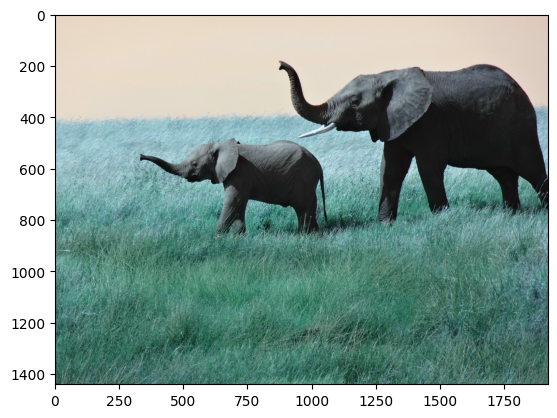

In [17]:
# cv2.imread reads image in BGR format unlikely to keras.preprocessing.image.load_img (reads RGB format)
# cv2.imread usually reads in images in uint8 precision, keras reads float32
# Keras format
#original_image = keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
#original_image = keras.preprocessing.image.img_to_array(original_image)
#original_image = image.astype(np.uint8)

# OpenCV format
original_image = cv2.imread(img_path)

plt.imshow(original_image)

In [29]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
image = keras.preprocessing.image.img_to_array(image)
image_batch = np.expand_dims(image, axis=0)
image_batch = keras.applications.imagenet_utils.preprocess_input(image_batch)
#plt.imshow((image_batch.squeeze()).astype(np.float32)/255.)

In [30]:
# Make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = vgg16_model.predict(image_batch)
class_id = np.argmax(preds[0])

1/1 [==============================] - 1s 904ms/step


In [31]:
# Decode the ImageNet predictions
decoded = keras.applications.imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

[INFO] African_elephant: 88.32%


In [32]:
class GradCAM:
  def __init__(self, model, layer_name=None):
    self.model = model
    self.layer_name = layer_name

    if self.layer_name is None:
      self.layer_name = self.find_target_layer()

  def find_target_layer(self):
    # Find the last convolutional layer of the model before Global Average Pooling
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output.shape) == 4:
            return layer.name
    # otherwise, we could not find a 4D layer
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, class_id, eps=1e-8):
    self.class_id = class_id
    # Construct gradient model by supplying the inputs to the pre-trained model
    # (The output of the final 4D layer in the network, and the output of the
    # softmax activations from the model
    gradModel = keras.Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layer_name).output, self.model.output])

    # Compute the gradients
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)  # cast the image tensor to a float-32
      (last_conv_layer_output, preds) = gradModel(inputs)
      loss = preds[:, self.class_id]

    # Compute the gradients for last convolutional layer
    grads = tape.gradient(loss, last_conv_layer_output)

    # Compute the guided gradients
    cast_conv_layer_output = tf.cast(last_conv_layer_output > 0, tf.float32)
    cast_grads = tf.cast(grads > 0, tf.float32)
    guided_grads = cast_conv_layer_output * cast_grads * grads

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    last_conv_layer_output = last_conv_layer_output[0]
    guided_grads = guided_grads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)

    # grab the spatial dimensions of the input image and resize the output class
    # activation map to match the input image dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # For visualization purpose normalize the heatmap such that
    # all values lie in the range [0, 1], scale the resulting values to the
    # range [0, 255], and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return the resulting heatmap to the calling function
    return heatmap

  # Combine Grad model output and the original image
  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")  # cm.get_cmap will be deprecated after few releases
    # jet = matplotlib.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]  # First 3 channel: R, G, B
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose/Combine the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    #heatmap = cv2.applyColorMap(heatmap, colormap)
    #superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

    return (heatmap, superimposed_img)

In [33]:
grad_cam = GradCAM(vgg16_model)

heatmap = grad_cam.compute_heatmap(image_batch, class_id)

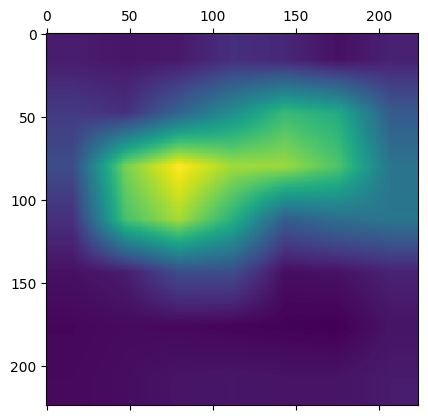

In [34]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [35]:
print("image.shape: ", image.shape)
print("original_image.shape: ", original_image.shape)
print("heatmap.shape: ", heatmap.shape)

image.shape:  (224, 224, 3)
original_image.shape:  (1440, 1920, 3)
heatmap.shape:  (224, 224)


In [36]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

print("heatmap.shape: ", heatmap.shape)

heatmap.shape:  (1440, 1920)


In [41]:
(heatmap, output) = grad_cam.overlay_heatmap(heatmap, image, alpha=0.8)

<ipython-input-32-0b55f4010598>:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")  # cm.get_cmap will be deprecated after few releases


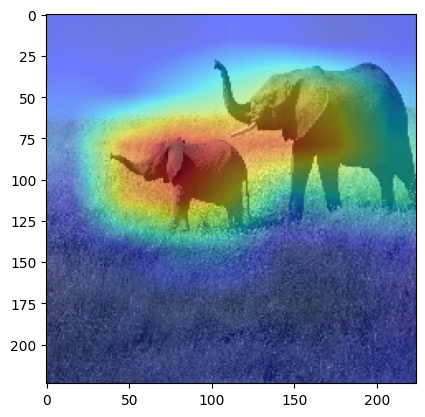

In [42]:
plt.imshow(output)

### Reference

https://www.youtube.com/watch?v=FjZpjMyQCu8

https://github.com/wiqaaas/youtube/blob/master/Deep_Learning_Using_Tensorflow/Demystifying_CNN/Gradient%20Visualization.ipynb